In [74]:
import torch, torchaudio, torchmetrics
from torch import nn
from torch.nn import functional as F
from torchmetrics import functional

In [61]:
import pytorch_lightning as pl

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [2]:
torch.cuda.is_available()

False

## step 1: loading the data

In [5]:
datapath = Path('data/')

In [6]:
datapath.exists()

True

In [13]:
csv = pd.read_csv(datapath/Path('meta/esc50.csv'))
csv.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [19]:
x, sr = torchaudio.load(datapath/'audio'/csv.iloc[0,0], normalize=True)

In [25]:
x

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

In [21]:
x.shape

torch.Size([1, 220500])

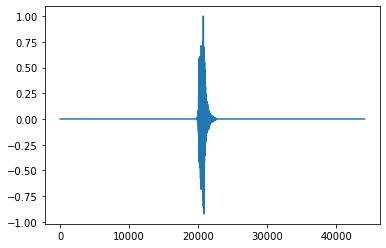

In [30]:
plt.plot(x[0,::5])

In [31]:
torchaudio.transforms.Resample(orig_freq=sr, new_freq=8000)(x).shape

torch.Size([1, 40000])

In [32]:
h = torchaudio.transforms.MelSpectrogram(sample_rate=sr)(x)

/home/lubuntu/miniconda3/envs/reprodl/lib/python3.9/site-packages/torchaudio/functional/functional.py:594: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [33]:
h.shape

torch.Size([1, 128, 1103])

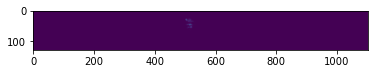

In [34]:
plt.imshow(h[0])

In [37]:
import IPython
IPython.display.Audio(datapath/'audio'/csv.iloc[0,0])

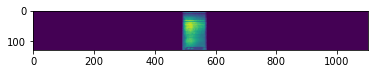

In [38]:
h = torchaudio.transforms.AmplitudeToDB()(h)
plt.imshow(h[0])

In [120]:
class ESC50Datatset(torch.utils.data.Dataset):
    def __init__(self, path: Path = Path('data/'), 
                 sample_rate: int = 8000,
                 folds = [1]):
        # load csv & initialize all torchaudio.transforms
        # Resample --> MelSpectrogram --> AmplitudeToDB
        self.path = path
        self.csv = pd.read_csv(path/Path('meta/esc50.csv'))
        self.csv = self.csv[self.csv.fold.isin(folds)]
        
        self.resample = torchaudio.transforms.Resample(orig_freq=44100, new_freq=sample_rate)
        self.melspec =  torchaudio.transforms.MelSpectrogram(sample_rate = sample_rate)
        self.db = torchaudio.transforms.AmplitudeToDB(top_db=80)
        
    def __getitem__(self, index):
        # return (xb, yb) pair
        row = self.csv.iloc[index]
        wav, _ = torchaudio.load(self.path/'audio'/row['filename'])
        label = row['target']
        xb = self.db(self.melspec(self.resample(wav)))
        return xb, label
    
    def __len__(self):
        # return length
        return len(self.csv)

In [121]:
train_data = ESC50Datatset()

In [122]:
for xb, yb in train_data:
    break

xb.shape

torch.Size([1, 128, 201])

## step 2 building the model

In [139]:
train_data = ESC50Datatset(folds=[1])
val_data = ESC50Datatset(folds=[2])
test_data = ESC50Datatset(folds=[3]) 

In [140]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=3, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=3, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=3, num_workers=4)

In [153]:
class AudioNet(pl.LightningModule):
    
    def __init__(self, n_classes = 50, base_filters = 16):
        super().__init__()
        self.conv1 = nn.Conv2d(1, base_filters, 11, padding=5)
        self.bn1 = nn.BatchNorm2d(base_filters)
        self.conv2 = nn.Conv2d(base_filters, base_filters, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(base_filters)
        self.pool1 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(base_filters, base_filters * 2, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(base_filters * 2)
        self.conv4 = nn.Conv2d(base_filters * 2, base_filters * 4, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(base_filters * 4)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(base_filters * 4, n_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool1(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool2(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = self.fc1(x[:, :, 0, 0])
        return x
    
    def training_step(self, batch, batch_idx):
        # Very simple training loop
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        #self.log('train_loss', loss, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat = torch.argmax(y_hat, dim=1)
        acc = functional.accuracy(y_hat, y)
        #self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        return acc
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat = torch.argmax(y_hat, dim=1)
        acc = functional.accuracy(y_hat, y)
        #self.log('test_acc', acc, on_epoch=True, prog_bar=True)
        return acc
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [154]:
pl.seed_everything(0)

Global seed set to 0


0

In [155]:
audionet = AudioNet()

In [156]:
xb, yb = next(iter(train_loader))
audionet(xb).shape

torch.Size([3, 50])

In [160]:
trainer = pl.Trainer(max_epochs=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [161]:
trainer.fit(audionet, train_loader, val_loader)


   | Name  | Type        | Params
---------------------------------------
0  | conv1 | Conv2d      | 2.0 K 
1  | bn1   | BatchNorm2d | 32    
2  | conv2 | Conv2d      | 2.3 K 
3  | bn2   | BatchNorm2d | 32    
4  | pool1 | MaxPool2d   | 0     
5  | conv3 | Conv2d      | 4.6 K 
6  | bn3   | BatchNorm2d | 64    
7  | conv4 | Conv2d      | 18.5 K
8  | bn4   | BatchNorm2d | 128   
9  | pool2 | MaxPool2d   | 0     
10 | fc1   | Linear      | 3.2 K 
---------------------------------------
30.9 K    Trainable params
0         Non-trainable params
30.9 K    Total params
0.124     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 0


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [162]:
trainer.test(audionet, test_loader)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]